In [225]:
import os
import site
from pathlib import Path
import importlib  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = Path(os.getcwd())
site.addsitedir(path.parent)  

dataset_cleaning = importlib.import_module("utils.dataset_cleaning")

# the datasets that are returned are cleaned
df_aircraft = dataset_cleaning.clean_aircraft(
    '../../Resources/ACchar.xlsx', 
    )

df_airport = dataset_cleaning.clean_airport(
    '../../Resources/training_set_airport_data.csv', 'train'
    )

df_geography = dataset_cleaning.clean_geography(
    '../../Resources/geographic_data.csv', 
    )

df_weather = dataset_cleaning.clean_weather(
    '../../Resources/Weather_data.csv', 'train'
    )

dataset_joining = importlib.import_module("utils.dataset_joining")

# joining cleaned datasets and combining them
# you do not have to list all datasets if you only want to join some of them
# but df_airport is the only one mandatory
merged_df = dataset_joining.join_datasets(df_airport, df_weather=df_weather,df_geography=df_geography, df_aircraft=df_aircraft)
merged_bkp = merged_df.copy()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning:

Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.



### Adding distance between stand and runway

In [226]:
pairs = pd.read_csv('../../Resources/new_pairs.csv')
pairs.columns = ['index','stand','runway','distance']
merged_df = pd.merge(merged_df, pairs,  how='left', left_on=['stand','runway'], right_on = ['stand','runway'])

### Adding target variable

In [227]:
merged_df.iloc[:,2] = pd.to_datetime(merged_df.iloc[:,2], errors = 'coerce')
merged_df.iloc[:,3] = pd.to_datetime(merged_df.iloc[:,3], errors = 'coerce')

variable = abs(merged_df.iloc[:,3] - merged_df.iloc[:,2])
merged_df['taxi_out']=variable.astype('int64')/(6*10**10)

In [228]:
N_Q_df = pd.read_pickle('./df_apt_time.pkl')
display(N_Q_df.head())
N_Q_df.columns = ['flight_datetime', 'ATOT', 'N', 'Q', 'N_rw', 'Q_rw']
display(N_Q_df.head())
display(merged_df.head())
merged_df = merged_df.merge(N_Q_df)

,Flight Datetime,ATOT,N,Q,N_rw,Q_rw
0,2015-01-01 06:00:00,2015-01-01 06:05:00,0,0,0,0
1,2015-01-01 06:10:00,2015-01-01 06:18:00,0,0,0,0
2,2015-01-01 06:15:00,2015-01-01 06:19:00,0,0,0,0
3,2015-01-01 06:20:00,2015-01-01 06:36:00,3,3,0,0
4,2015-01-01 06:20:00,2015-01-01 06:27:00,2,2,1,1


,flight_datetime,ATOT,N,Q,N_rw,Q_rw
0,2015-01-01 06:00:00,2015-01-01 06:05:00,0,0,0,0
1,2015-01-01 06:10:00,2015-01-01 06:18:00,0,0,0,0
2,2015-01-01 06:15:00,2015-01-01 06:19:00,0,0,0,0
3,2015-01-01 06:20:00,2015-01-01 06:36:00,3,3,0,0
4,2015-01-01 06:20:00,2015-01-01 06:27:00,2,2,1,1


,flight_datetime,aircraft_model,AOBT,ATOT,stand,runway,time_hourly,summary,temperature,dewPoint,...,wheelbase_feet,cockpit_to_main_gear_feet,main_gear_width,max_takeoff_weight,max_ramp_taxi_weight,parking_area_square_feet,number_gear_types_tandem,index,distance,taxi_out
0,2015-01-01 06:00:00,B737-800 WINGLETS,2015-01-01 05:56:00,2015-01-01 06:05:00,STAND_62,RUNWAY_4,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,51.1667,56.4167,22.9583,174200,174900,15205.5,1,560.0,1150.0,9.0
1,2015-01-01 06:10:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:18:00,STAND_153,RUNWAY_4,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,41.47,50.2,29.36,171961,172842,13791.4,1,651.0,1175.0,10.0
2,2015-01-01 06:15:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:19:00,STAND_44,RUNWAY_2,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,41.47,50.2,29.36,171961,172842,13791.4,1,210.0,3150.0,11.0
3,2015-01-01 06:20:00,A320-100/200,2015-01-01 06:24:00,2015-01-01 06:36:00,STAND_7,RUNWAY_3,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,41.47,50.2,29.36,171961,172842,13791.4,1,339.0,3100.0,12.0
4,2015-01-01 06:20:00,A319,2015-01-01 06:14:00,2015-01-01 06:27:00,STAND_17,RUNWAY_2,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,36.23,44.9,29.36,168653,169535,12420.9,1,183.0,2800.0,13.0


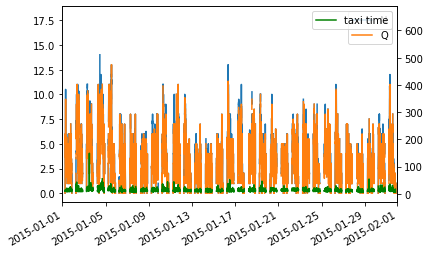

In [229]:
fig,ax = plt.subplots()
plot_n_q = N_Q_df[['flight_datetime','N', 'Q']].set_index('flight_datetime').resample('5min').mean()
ax.plot(plot_n_q['N'], label='N')
ax.plot(plot_n_q['Q'], label = 'Q')
plt.legend()
ax2 = ax.twinx()
plt_taxi = merged_df[['flight_datetime', 'taxi_out']].set_index('flight_datetime').resample('5min').mean()
ax2.plot(plt_taxi, label='taxi time', color='green')
plt.legend()
plt.xlim(np.datetime64('2015-01-01'), np.datetime64('2015-02-01'))
fig.autofmt_xdate()
plt.show()


In [230]:
from fbprophet import Prophet
#del(m)
m = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
m.add_country_holidays(country_name='UK')
df_proph = merged_df[['flight_datetime', 'taxi_out']]
df_proph.columns = ['ds', 'y']
df_proph = df_proph.set_index('ds').resample('5min').mean()
df_proph.reset_index(inplace=True)
m.fit(df_proph)

In [216]:
m_n = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
m_n.add_country_holidays(country_name='UK')
df_proph_n = merged_df[['flight_datetime', 'N']]
df_proph_n.columns = ['ds', 'y']
df_proph_n = df_proph_n.set_index('ds').resample('5min').mean()
df_proph_n.reset_index(inplace=True)
m_n.fit(df_proph)

In [217]:
m_q = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
m_q.add_country_holidays(country_name='UK')
df_proph_q = merged_df[['flight_datetime', 'Q']]
df_proph_q.columns = ['ds', 'y']
df_proph_q = df_proph_q.set_index('ds').resample('5min').mean()
df_proph_q.reset_index(inplace=True)
m_q.fit(df_proph)

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



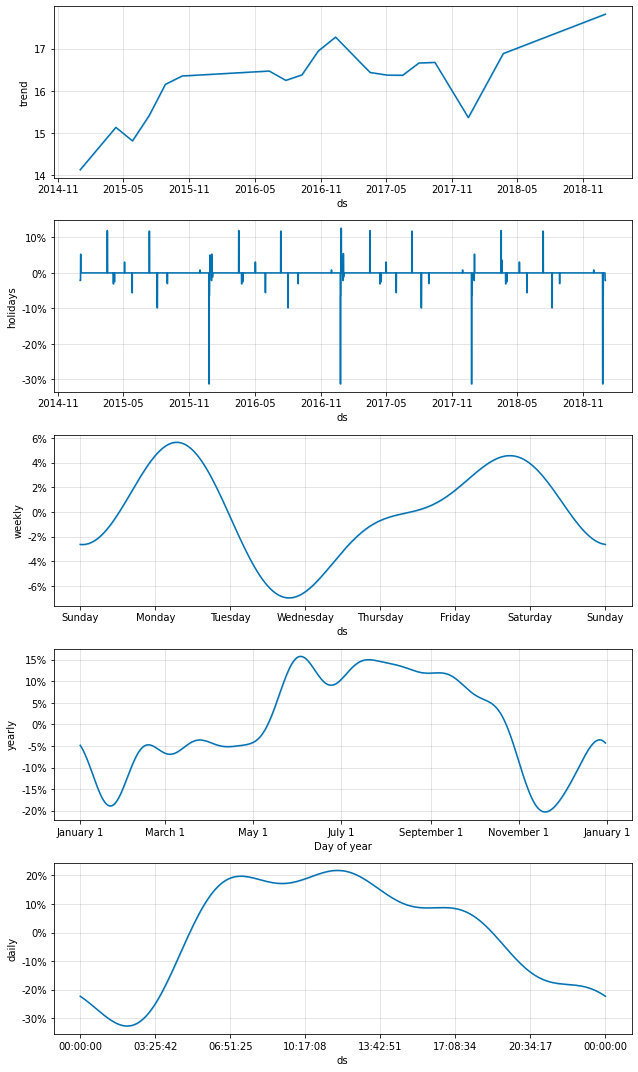

In [218]:
fig = m_n.plot_components(forecast)

<Figure size 1440x720 with 0 Axes>

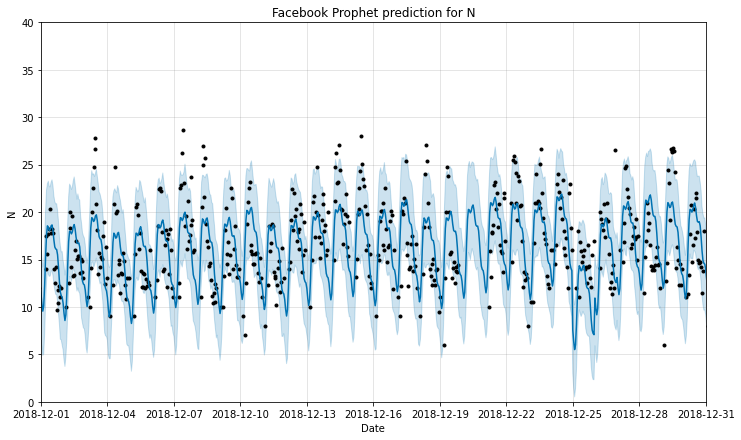

In [277]:
plt.figure(figsize=(20,10))
fig1 = m_n.plot(forecast)
plt.xlim(np.datetime64('2018-12-01'),np.datetime64('2018-12-31'))
plt.xlabel('Date')
plt.ylabel('N')
plt.title('Facebook Prophet prediction for N')
plt.ylim(0,40)
plt.show()

In [231]:
merged_df = merged_df.dropna()
merged_df['rounded_hour'] = merged_df['flight_datetime'].dt.round('H')
merged_df['rounded_5m'] = merged_df['flight_datetime'].dt.round('5min')
fb_prophet_est = m.history[['ds', 'y']]
fb_prophet_est.columns = ['rounded_5m', 'Taxi_prophet']
merged_df = merged_df.merge(fb_prophet_est)
fb_prophet_est = m_n.history[['ds', 'y']]
fb_prophet_est.columns = ['rounded_5m', 'N_prophet']
merged_df = merged_df.merge(fb_prophet_est)
fb_prophet_est = m_q.history[['ds', 'y']]
fb_prophet_est.columns = ['rounded_5m', 'Q_prophet']
merged_df = merged_df.merge(fb_prophet_est)

### Remove outliers

In [232]:
merged_df = merged_df[merged_df['taxi_out']<500]
merged_df['delay'] = (abs(merged_df['flight_datetime'] - merged_df['AOBT'])).astype('int64')/(6*10**10)

In [233]:
merged_df['taxi_out_mov_avg'] = merged_df.set_index('flight_datetime')['taxi_out'].rolling('60D', min_periods=1).mean().values

In [234]:
test = merged_df.groupby(['stand', 'runway']).median()[['distance', 'taxi_out']]
test['vel'] = test['distance']/test['taxi_out']
merged_df = merged_df.merge(test['vel'], left_on = ['stand', 'runway'], right_on=['stand', 'runway'])

### Isolating the target variable

In [235]:
y = merged_df.pop('taxi_out')

In [236]:
merged_df

,flight_datetime,aircraft_model,AOBT,ATOT,stand,runway,time_hourly,summary,temperature,dewPoint,...,N_rw,Q_rw,rounded_hour,rounded_5m,Taxi_prophet,N_prophet,Q_prophet,delay,taxi_out_mov_avg,vel
0,2015-01-01 06:00:00,B737-800 WINGLETS,2015-01-01 05:56:00,2015-01-01 06:05:00,STAND_62,RUNWAY_4,2015-01-01 06:00:00,Cloudy,44.65,42.80,...,0,0,2015-01-01 06:00:00,2015-01-01 06:00:00,9.000000,11.000000,11.000000,4.0,9.000000,63.888889
1,2015-01-04 08:00:00,B737-800 WINGLETS,2015-01-04 08:26:00,2015-01-04 08:41:00,STAND_62,RUNWAY_4,2015-01-04 08:00:00,Foggy,35.65,33.78,...,3,2,2015-01-04 08:00:00,2015-01-04 08:00:00,16.000000,16.166667,16.166667,26.0,14.510490,63.888889
2,2015-01-20 10:00:00,A321-100/200,2015-01-20 09:59:00,2015-01-20 10:14:00,STAND_62,RUNWAY_4,2015-01-20 10:00:00,Clear,26.68,26.62,...,0,0,2015-01-20 10:00:00,2015-01-20 10:00:00,14.500000,15.066667,15.066667,1.0,14.709302,63.888889
3,2015-01-25 16:00:00,A319,2015-01-25 16:08:00,2015-01-25 16:22:00,STAND_62,RUNWAY_4,2015-01-25 16:00:00,Cloudy,46.46,37.40,...,2,2,2015-01-25 16:00:00,2015-01-25 16:00:00,13.250000,13.000000,13.000000,8.0,14.723819,63.888889
4,2015-02-04 08:00:00,A319,2015-02-04 08:06:00,2015-02-04 08:21:00,STAND_62,RUNWAY_4,2015-02-04 08:00:00,Cloudy,33.84,32.02,...,2,2,2015-02-04 08:00:00,2015-02-04 08:00:00,20.500000,16.277778,16.277778,6.0,14.415038,63.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64984,2018-11-21 07:00:00,A319,2018-11-21 06:59:00,2018-11-21 07:10:00,STAND_10,RUNWAY_2,2018-11-21 07:00:00,Clear,35.31,33.78,...,0,0,2018-11-21 07:00:00,2018-11-21 07:00:00,12.250000,17.680000,17.680000,1.0,19.290358,136.052632
64985,2018-11-26 17:00:00,A320-100/200,2018-11-26 17:33:00,2018-11-26 17:52:00,STAND_10,RUNWAY_2,2018-11-26 17:00:00,Clear,44.65,41.00,...,1,1,2018-11-26 17:00:00,2018-11-26 17:00:00,17.333333,19.550000,19.550000,33.0,19.062664,136.052632
64986,2018-12-07 09:00:00,A330-300,2018-12-07 09:40:00,2018-12-07 10:09:00,STAND_10,RUNWAY_2,2018-12-07 09:00:00,Clear,53.65,51.79,...,4,4,2018-12-07 09:00:00,2018-12-07 09:00:00,25.333333,26.269231,26.269231,40.0,18.404297,136.052632
64987,2018-12-07 12:00:00,A319,2018-12-07 12:14:00,2018-12-07 12:35:00,STAND_10,RUNWAY_2,2018-12-07 12:00:00,Clear,50.05,48.20,...,2,1,2018-12-07 12:00:00,2018-12-07 12:00:00,19.750000,18.521739,18.521739,14.0,18.413349,136.052632


In [360]:
X = merged_df

In [361]:
X['flight_day']=X['flight_datetime'].dt.day_name()

In [362]:
X['flight_month']=X['flight_datetime'].dt.month_name()

In [363]:
val = (X['flight_datetime'].dt.hour % 24 + 4) // 4
val.replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [364]:
X['day_moment']=val

In [365]:
X = X.drop(['flight_datetime','aircraft_model','AOBT','ATOT','stand','index','time_hourly','manufacturer','full_aircraft_model'], axis=1)

In [366]:
X.columns

Index(['runway', 'summary', 'temperature', 'dewPoint', 'humidity', 'windSpeed',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'Lat_runway', 'Lng_runway', 'Lat_stand', 'Lng_stand', 'engine class',
       'number_engines', 'approach_speed', 'wingtip_config', 'wingspan_feet',
       'length_feet', 'tail_height_feet', 'wheelbase_feet',
       'cockpit_to_main_gear_feet', 'main_gear_width', 'max_takeoff_weight',
       'max_ramp_taxi_weight', 'parking_area_square_feet',
       'number_gear_types_tandem', 'distance', 'N', 'Q', 'N_rw', 'Q_rw',
       'rounded_hour', 'rounded_5m', 'Taxi_prophet', 'N_prophet', 'Q_prophet',
       'delay', 'taxi_out_mov_avg', 'vel', 'flight_day', 'flight_month',
       'day_moment'],
      dtype='object')

In [367]:
X['number_engines'] = pd.to_numeric(X['number_engines'], downcast="float")
X['wingspan_feet'] = pd.to_numeric(X['wingspan_feet'], downcast="float")
X['length_feet'] = pd.to_numeric(X['length_feet'], downcast="float")
X['tail_height_feet'] = pd.to_numeric(X['tail_height_feet'], downcast="float")
X['wheelbase_feet'] = pd.to_numeric(X['wheelbase_feet'], downcast="float")
X['cockpit_to_main_gear_feet'] = pd.to_numeric(X['cockpit_to_main_gear_feet'], downcast="float")
X['main_gear_width'] = pd.to_numeric(X['main_gear_width'], downcast="float")
X['max_takeoff_weight'] = pd.to_numeric(X['max_takeoff_weight'], downcast="float")
X['max_ramp_taxi_weight'] = pd.to_numeric(X['max_ramp_taxi_weight'], downcast="float")
X['parking_area_square_feet'] = pd.to_numeric(X['parking_area_square_feet'], downcast="float")

In [368]:
X.select_dtypes('object').columns.tolist()

['runway',
 'summary',
 'engine class',
 'wingtip_config',
 'number_gear_types_tandem',
 'flight_day',
 'flight_month',
 'day_moment']

In [369]:
from sklearn.preprocessing import OneHotEncoder

# seleziona le features non numeriche
cat_column_names = X.select_dtypes('object').columns.tolist()
print(cat_column_names)
#cat_column_names.remove('Note')
#cat_column_names.remove('Years Manufactured')
#cat_column_names.remove('Wheelbase, ft')



# Fit dell'encoder sul train
ohe = OneHotEncoder(
    sparse=False,
    handle_unknown='ignore'  # mette tutti zero nel caso trovassimo classi sconosciute durante il "transform"
)
# converto in stringa, così anche eventuali nulli saranno categorie, poi faccio fit
ohe.fit(X[cat_column_names].astype(str))

# l'output di OneHotEncoder.transform sarà un numpy array, ma lo voglio ritrasformare in pandas dataframe
new_column_names = [
    f"{category} - {level}" for category, level_list in zip(cat_column_names, ohe.categories_)
    for level in level_list]

X_ohe = pd.DataFrame(
    ohe.transform(X[cat_column_names].astype(str)),
    index=X.index,
    columns=new_column_names)

# butto via le vecchie colonne categoriche e aggiungo le nuove
X = pd.concat([
    X.drop(cat_column_names, axis=1),
    X_ohe], axis=1)


['runway', 'summary', 'engine class', 'wingtip_config', 'number_gear_types_tandem', 'flight_day', 'flight_month', 'day_moment']


In [370]:
X.columns

Index(['temperature', 'dewPoint', 'humidity', 'windSpeed', 'windGust',
       'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'Lat_runway',
       'Lng_runway', 'Lat_stand', 'Lng_stand', 'number_engines',
       'approach_speed', 'wingspan_feet', 'length_feet', 'tail_height_feet',
       'wheelbase_feet', 'cockpit_to_main_gear_feet', 'main_gear_width',
       'max_takeoff_weight', 'max_ramp_taxi_weight',
       'parking_area_square_feet', 'distance', 'N', 'Q', 'N_rw', 'Q_rw',
       'rounded_hour', 'rounded_5m', 'Taxi_prophet', 'N_prophet', 'Q_prophet',
       'delay', 'taxi_out_mov_avg', 'vel', 'runway - RUNWAY_1',
       'runway - RUNWAY_2', 'runway - RUNWAY_3', 'runway - RUNWAY_4',
       'summary - Clear', 'summary - Clouds and Wind', 'summary - Cloudy',
       'summary - Dangerously Windy', 'summary - Drizzle', 'summary - Foggy',
       'summary - Possible Drizzle', 'summary - Possible Light Rain',
       'summary - Rain', 'summary - Rain and Wind', 'engine class - Jet',
   

### Remove outliers

### Applying a scaling

In [371]:
X.select_dtypes('float').columns.tolist()

['temperature',
 'dewPoint',
 'humidity',
 'windSpeed',
 'windGust',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'visibility',
 'Lat_runway',
 'Lng_runway',
 'Lat_stand',
 'Lng_stand',
 'approach_speed',
 'distance',
 'Taxi_prophet',
 'N_prophet',
 'Q_prophet',
 'delay',
 'taxi_out_mov_avg',
 'vel',
 'runway - RUNWAY_1',
 'runway - RUNWAY_2',
 'runway - RUNWAY_3',
 'runway - RUNWAY_4',
 'summary - Clear',
 'summary - Clouds and Wind',
 'summary - Cloudy',
 'summary - Dangerously Windy',
 'summary - Drizzle',
 'summary - Foggy',
 'summary - Possible Drizzle',
 'summary - Possible Light Rain',
 'summary - Rain',
 'summary - Rain and Wind',
 'engine class - Jet',
 'engine class - Turboprop',
 'wingtip_config - no winglets',
 'wingtip_config - winglets',
 'wingtip_config - wingtip fences',
 'number_gear_types_tandem - 1',
 'number_gear_types_tandem - 2',
 'number_gear_types_tandem - 3',
 'flight_day - Friday',
 'flight_day - Monday',
 'flight_day - Saturday',
 'flight_day - Sunday',
 'flig

In [372]:
#X = X.drop('index',axis=1)
#X = X.drop('taxi_out',axis=1)

In [373]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['temperature','dewPoint','humidity','windSpeed','windGust','windBearing','cloudCover',
 'uvIndex','visibility','approach_speed','distance', 'max_ramp_taxi_weight', 'max_takeoff_weight']
X[num_cols] = scaler.fit_transform(X[num_cols])
X_bkp = X.copy()

In [391]:
X = X_bkp.copy()
X = X.drop(['parking_area_square_feet', 'length_feet', 'max_takeoff_weight', 'max_ramp_taxi_weight','rounded_5m','Lat_runway','Lng_runway','Lat_stand','Lng_stand', 'vel', 'rounded_hour', 'Q','N_prophet', 'N_rw', 'Q_rw'], axis=1)
#X['N_Q'] = X['N']*X['Q']

In [392]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [393]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43542 entries, 25593 to 56422
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   temperature                      43542 non-null  float64
 1   dewPoint                         43542 non-null  float64
 2   humidity                         43542 non-null  float64
 3   windSpeed                        43542 non-null  float64
 4   windGust                         43542 non-null  float64
 5   windBearing                      43542 non-null  float64
 6   cloudCover                       43542 non-null  float64
 7   uvIndex                          43542 non-null  float64
 8   visibility                       43542 non-null  float64
 9   number_engines                   43542 non-null  float32
 10  approach_speed                   43542 non-null  float64
 11  wingspan_feet                    43542 non-null  float32
 12  tail_height_fe

In [394]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.5469672755630217

In [395]:
pd.DataFrame(columns=['name', 'value'])

,name,value


In [396]:
test = pd.DataFrame(columns=['name', 'value'])
test['name'] = X.columns
test['value'] = reg.coef_
test.sort_values(by='value')

,name,value
41,number_gear_types_tandem - 1,-0.647961
66,day_moment - Morning,-0.610791
36,engine class - Jet,-0.605861
31,summary - Foggy,-0.523113
68,day_moment - Noon,-0.505042
...,...,...
37,engine class - Turboprop,0.605861
18,Taxi_prophet,0.927080
65,day_moment - Late Night,1.111866
33,summary - Possible Light Rain,1.170708


In [397]:

time_windows = [3, 5]

for time in time_windows:
    # making predictions
    predictions_gbm['lower'] = reg.predict(X_test)-time
    predictions_gbm['prediction'] = reg.predict(X_test)
    predictions_gbm['upper'] = reg.predict(X_test)+time

    predictions_gbm['in'] = predictions_gbm['taxi_out']\
        .between(predictions_gbm['lower'], predictions_gbm['upper'])

    acc = round(sum(predictions_gbm['in']) / len(predictions_gbm) * 100, 2)

    print('Accuracy for a time-window of', time, 'min:', acc, '%')

Accuracy for a time-window of 3 min: 65.96 %
Accuracy for a time-window of 5 min: 83.78 %


In [398]:
predictions_gbm['lower'] = reg.predict(X_test)-5
predictions_gbm['prediction'] = reg.predict(X_test)
predictions_gbm['upper'] = reg.predict(X_test)+5

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 5 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

accuracy within 5 minutes error with gbm:  83.78 %


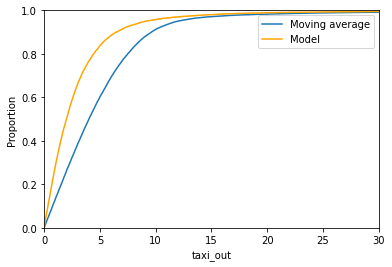

In [293]:
fig, ax = plt.subplots()
sns.ecdfplot(abs(merged_df['taxi_out_mov_avg'] - y), ax=ax, label='Moving average')
sns.ecdfplot(abs(reg.predict(X_test) - y_test), color='orange', ax=ax, label='Model')
plt.legend()
plt.xlim(0,30)
plt.show()

In [402]:
from sklearn.ensemble import GradientBoostingRegressor
xgb = GradientBoostingRegressor()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.5276527183585982

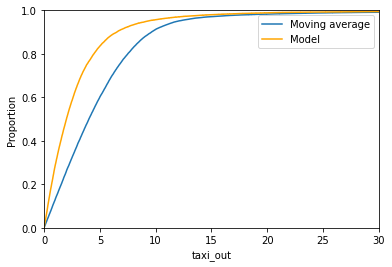

In [403]:
fig, ax = plt.subplots()
sns.ecdfplot(abs(merged_df['taxi_out_mov_avg'] - y), ax=ax, label='Moving average')
sns.ecdfplot(abs(xgb.predict(X_test) - y_test), color='orange', ax=ax, label='Model')
plt.legend()
plt.xlim(0,30)
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.ecdfplot(abs(merged_df['taxi_out_mov_avg'] - y), ax=ax, label='Moving average')
sns.ecdfplot(abs(xgb.predict(X_train) - y_train), color='orange', ax=ax, label='Model')
plt.legend()
plt.xlim(0,10)
plt.xlabel('Error between the actual taxing time and predicted in minutes')
plt.ylabel('Empirical cumulative distribution function')
plt.show()

In [ ]:
np.percentile(abs(merged_df['taxi_out_mov_avg'] - y), 95)

In [ ]:
np.percentile(abs(xgb.predict(X_train) - y_train), 95)

In [ ]:
from sklearn.linear_model import SGDRegressor
regr = SGDRegressor(max_iter=1000, tol=1e-3)
regr.fit(X_train, y_train)


In [400]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(num_leaves=400,
                            learning_rate=0.05,
                            n_estimators=500)
model = gbm.fit(X_train, y_train,
                    eval_set=[(X_test, y_test)],
                    eval_metric='l1',
                    early_stopping_rounds=30)
predictions_gbm = pd.DataFrame(y_test)

time_windows = [3, 5]

for time in time_windows:
    # making predictions
    predictions_gbm['lower'] = gbm.predict(X_test)-time
    predictions_gbm['prediction'] = gbm.predict(X_test)
    predictions_gbm['upper'] = gbm.predict(X_test)+time

    predictions_gbm['in'] = predictions_gbm['taxi_out']\
        .between(predictions_gbm['lower'], predictions_gbm['upper'])

    acc = round(sum(predictions_gbm['in']) / len(predictions_gbm) * 100, 2)

    print('Accuracy for a time-window of', time, 'min:', acc, '%')

[1]	valid_0's l1: 5.18599	valid_0's l2: 61.1456
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l1: 5.02562	valid_0's l2: 58.2218
[3]	valid_0's l1: 4.87868	valid_0's l2: 55.6384
[4]	valid_0's l1: 4.74257	valid_0's l2: 53.2846
[5]	valid_0's l1: 4.61794	valid_0's l2: 51.2206
[6]	valid_0's l1: 4.50216	valid_0's l2: 49.3282
[7]	valid_0's l1: 4.39479	valid_0's l2: 47.6208
[8]	valid_0's l1: 4.29565	valid_0's l2: 46.0736
[9]	valid_0's l1: 4.20345	valid_0's l2: 44.6726
[10]	valid_0's l1: 4.11717	valid_0's l2: 43.3641
[11]	valid_0's l1: 4.03882	valid_0's l2: 42.2339
[12]	valid_0's l1: 3.96594	valid_0's l2: 41.1893
[13]	valid_0's l1: 3.89893	valid_0's l2: 40.2609
[14]	valid_0's l1: 3.83765	valid_0's l2: 39.4199
[15]	valid_0's l1: 3.78081	valid_0's l2: 38.6475
[16]	valid_0's l1: 3.7292	valid_0's l2: 37.9607
[17]	valid_0's l1: 3.68254	valid_0's l2: 37.3824
[18]	valid_0's l1: 3.63872	valid_0's l2: 36.7932
[19]	valid_0's l1: 3.59847	valid_0's l2: 36.3127
[20]	valid_0's l1:

In [ ]:

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

# Loading some example data

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X_train, y_train)



In [ ]:
ereg.score(X_test, y_test)

In [279]:
predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = xgb.predict(X_test)-3
predictions_gbm['prediction'] = xgb.predict(X_test)
predictions_gbm['upper'] = xgb.predict(X_test)+3

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 3 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

accuracy within 3 minutes error with gbm:  64.74 %


In [ ]:
predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = ereg.predict(X_test)-5
predictions_gbm['prediction'] = ereg.predict(X_test)
predictions_gbm['upper'] = ereg.predict(X_test)+5

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 5 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
fig, ax = plt.subplots()
sns.ecdfplot(abs(merged_df['taxi_out_mov_avg'] - y), ax=ax, label='Moving average')
sns.ecdfplot(abs(ereg.predict(X_test) - y_test), color='orange', ax=ax, label='Model')
plt.legend()
plt.xlim(0,30)
plt.show()

In [ ]:
np.percentile(abs(ereg.predict(X_test) - y_test), 95)

In [ ]:
np.percentile(abs(merged_df['taxi_out_mov_avg'] - y), 95)

In [ ]:
np.percentile(abs(xgb.predict(X_test) - y_test), 95)

In [ ]:
pd.read_excel('../../Resources/test_set_weather_data.xlsx')

In [ ]:
df_weather

In [ ]:
dataset_cleaning = importlib.import_module("utils.dataset_cleaning")
test_airp = dataset_cleaning.clean_airport('../../Resources/test_set_airport_data.xlsx', 'test')

In [ ]:
dataset_cleaning = importlib.import_module("utils.dataset_cleaning")


In [ ]:
test_airp.columns = df_airport.columns

In [ ]:
dataset_cleaning.clean_airport()

In [ ]:
df_weather

In [ ]:
predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = X['taxi_out_mov_avg']-3
predictions_gbm['prediction'] = X['taxi_out_mov_avg']
predictions_gbm['upper'] = X['taxi_out_mov_avg']+3

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 3 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
#X_test.predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = X['taxi_out_mov_avg']-5
predictions_gbm['prediction'] = X['taxi_out_mov_avg']
predictions_gbm['upper'] = X['taxi_out_mov_avg']+5

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 5 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
predictions_gbm['lower'] = reg.predict(X_test)-3
predictions_gbm['prediction'] = reg.predict(X_test)
predictions_gbm['upper'] = reg.predict(X_test)+3

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 3 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
predictions_gbm['lower'] = reg.predict(X_test)-5
predictions_gbm['prediction'] = reg.predict(X_test)
predictions_gbm['upper'] = reg.predict(X_test)+5

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 5 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [307]:
import pickle

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.16155957 0.11054076 0.08514626 0.07000915 0.06000784 0.0529481
 0.04773351 0.04375572 0.04065047 0.03818681 0.03621163 0.03461991
 0.03333769 0.03231191 0.03150412 0.03088639 0.03043876 0.03014748
 0.03000392]
INFO:shap:num_paired_subset_sizes = 20
INFO:shap:weight_left = 0.7604324671571354
INFO:shap:np.sum(w_aug) = 41.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           3.05691528   2.19177733  -1.04320462  -1.3043359
   0.           0.          60.28277697 -58.50412978  -5.61277382
   0.           0.          -2.31038475   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.        ]


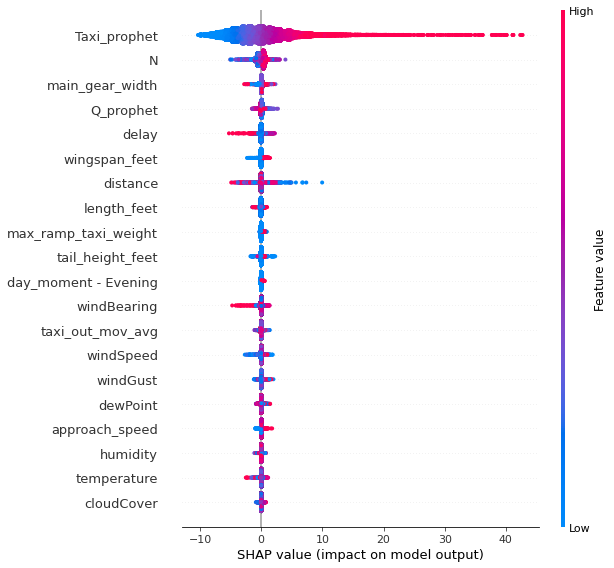

In [318]:
import shap
shap_values = shap.TreeExplainer(gbm).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [320]:
X_train_summary = shap.kmeans(X_train, 50)

def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

ex = shap.KernelExplainer(reg.predict, X_train_summary)
shap_values = ex.shap_values(X_test.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[0,:])



INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502767 0.03260151 0.03061361 0.02896519
 0.02758589 0.02642438 0.02544239 0.02461094 0.02390777 0.02331563
 0.02282106 0.02241354 0.02208489 0.02182884 0.02164066 0.021517
 0.02145569]
INFO:shap:num_paired_subset_sizes = 26
INFO:shap:weight_left = 0.7754030634555391
INFO:shap:np.sum(w_aug) = 52.999999999999986
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           3.09599116   2.08240412  -1.12475712  -1.31663244
   0.           0.          59.23791361 -57.47911734  -5.12899156
   0.           0.          -2.24525787   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.  

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502767 0.03260151 0.03061361 0.02896519
 0.02758589 0.02642438 0.02544239 0.02461094 0.02390777 0.02331563
 0.02282106 0.02241354 0.02208489 0.02182884 0.02164066 0.021517
 0.02145569]
INFO:shap:num_paired_subset_sizes = 26
INFO:shap:weight_left = 0.7754030634555391
INFO:shap:np.sum(w_aug) = 53.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           3.11747856   2.1962754   -1.05420383  -1.2463208
   0.           0.          59.24508151 -57.44251625  -5.04943211
   0.           0.          -2.19312746   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   

INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502767 0.03260151 0.03061361 0.02896519
 0.02758589 0.02642438 0.02544239 0.02461094 0.02390777 0.02331563
 0.02282106 0.02241354 0.02208489 0.02182884 0.02164066 0.021517
 0.02145569]
INFO:shap:num_paired_subset_sizes = 26
INFO:shap:weight_left = 0.7754030634555391
INFO:shap:np.sum(w_aug) = 52.999999999999986
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           2.84554428   5.5067873    0.          -2.54913481
   0.           0.          62.73376569 -61.04018665  -7.44437873
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0. 

INFO:shap:num_paired_subset_sizes = 25
INFO:shap:weight_left = 0.7743637981496906
INFO:shap:np.sum(w_aug) = 52.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           3.0574353    5.76300554  -1.17570318  -2.47185852
   0.           0.          62.82077208 -60.88364435  -7.1863552
   0.           0.           8.85560339   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14698953 0.09999288 0.07655705 0.06254874 0.05325708 0.04666334
 0.04175839 0.03798179 0.03499751 0.03259191 0.03062282 0.

INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999998
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.76599379   3.03582716  -4.70739756  -1.24910029   1.86815431
   0.80535601   0.          33.22983325 -32.48240799  -1.30108489
   0.           0.70098779  -1.58918792   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14698953 0.09999288 0.07655705 0.06254874 0.05325708 0.04666334
 0.04175839 0.03798179 0.03499751 0.03259191 0.03062282 0.02899202
 0.02762961 0.0264846  0.02551902 0.02470412 0.0240179  0.02344331
 0.02296711 0.0225790

INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           3.16738154   5.79597757  -1.09785392  -2.4625232
   0.           0.          62.76865616 -60.89001893  -7.19503234
   0.           0.          -1.31841075   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502767 0.03260151 0.03061361 0.02896519
 0.02758589 0.02642438 0.02544239 0.02461094 0.02390777 0.02331563
 0.02282106 0.02241354 0.02208489 0.02182884 0.02164066 0.021517
 0.02145569]
IN

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14698953 0.09999288 0.07655705 0.06254874 0.05325708 0.04666334
 0.04175839 0.03798179 0.03499751 0.03259191 0.03062282 0.02899202
 0.02762961 0.0264846  0.02551902 0.02470412 0.0240179  0.02344331
 0.02296711 0.02257904 0.02227114 0.02203741 0.02187344 0.02177623
 0.02174401]
INFO:shap:num_paired_subset_sizes = 25
INFO:shap:weight_left = 0.7743637981496906
INFO:shap:np.sum(w_aug) = 52.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
   -3.73519093   11.94948224   16.71966103   -7.44079034   -4.01785774
    0.           -4.59277455  199.75870953 -193.55510109  -17.02270153
    0.            0.            7.86492164    0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.   

INFO:shap:num_paired_subset_sizes = 26
INFO:shap:weight_left = 0.7754030634555391
INFO:shap:np.sum(w_aug) = 52.99999999999999
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           3.12174416   2.11727719  -1.09143613  -1.23250845
   0.           0.          59.3585047  -57.49944311  -5.10517468
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502767 0.03260151

INFO:shap:num_paired_subset_sizes = 26
INFO:shap:weight_left = 0.7754030634555391
INFO:shap:np.sum(w_aug) = 52.99999999999999
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999998
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           2.93982507   5.61014952  -1.25257377  -2.59391969
   0.           0.          62.63649546 -60.98333946  -7.3149138
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502

INFO:shap:np.sum(w_aug) = 52.999999999999986
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.          -1.87909078  57.18164445 -54.83801528  -2.6037119
   0.           0.          -4.84232989   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502767 0.03260151 0.03061361 0.02896519
 0.02758589 0.02642438 0.02544239 0.02461094 0.02390777 0.02331563


INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.          -21.55339349  -22.7149907     9.00994962    8.85932372
    0.            0.         -329.68121744  320.07480509   38.41567259
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502767 0.03260151 0.03061361 0.02896519
 0.02758589 0.02642438 0.02544239 0

INFO:shap:num_paired_subset_sizes = 26
INFO:shap:weight_left = 0.7754030634555391
INFO:shap:np.sum(w_aug) = 52.99999999999999
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999998
INFO:shap:phi = [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.          -19.93029256  -21.54749934    6.76948502    9.71988233
    0.            0.         -355.53415627  345.90939589   36.64921252
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14698953 0.09999288 0.07655705 0.0625487

INFO:shap:weight_left = 0.7743637981496906
INFO:shap:np.sum(w_aug) = 52.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.          -1.71912356  57.41994942 -54.67830485  -2.34443236
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14698953 0.09999288 0.07655705 0.06254874 0.05325708 0.04666334
 0.04175839 0.03798179 0.03499751 0.03259191 0.03062282 0.02899202
 0.02762961 0.0264846  0.02551902 0.02470412 0.024

INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.          -21.61394451  -23.2319914     8.42410096    9.00039202
    0.            0.         -329.27210791  319.36827509   37.90138568
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14766565 0.10041264 0.07684641 0.0627579  0.05341098 0.04677608
 0.0418386  0.03803509 0.03502767 0.03260151 0.03061361 0.02896519
 0.02758589 0.02642438 0.02544239 0.02461094 0.023

INFO:shap:phi = [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.          -21.82731156  -23.47686401    8.12487165    8.41160887
    0.            4.17869706 -329.92066159  318.92366851   37.32719956
    0.            0.            7.23988502    0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.        ]
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.14957673 0.10179528 0.07797085 0.06373269 0.05429081 0.0475926
 0.04261198 0.03877915 0.03575249 0.03331482 0.03132162 0.02967312
 0.0282983  0.02714541 0.02617593 0.02536076 0.02467764 0.02410941
 0.02364277 0.02326749 0.02

INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           3.13857523   2.18426551  -1.03296315  -1.12396502
   0.           0.          59.35601126 -57.42195379  -4.99627679
   0.           0.          -1.64141409   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.        ]


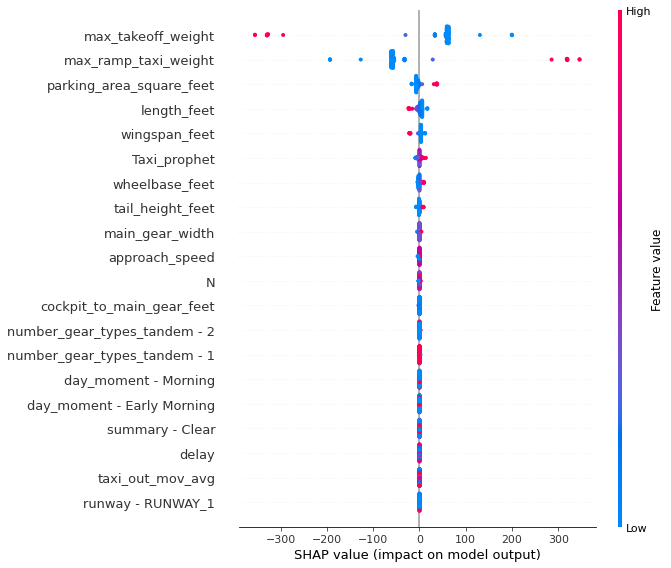

In [328]:
shap_values = ex.shap_values(X_test.iloc[:100,:])
shap.summary_plot(shap_values, X_test.iloc[:100,:])



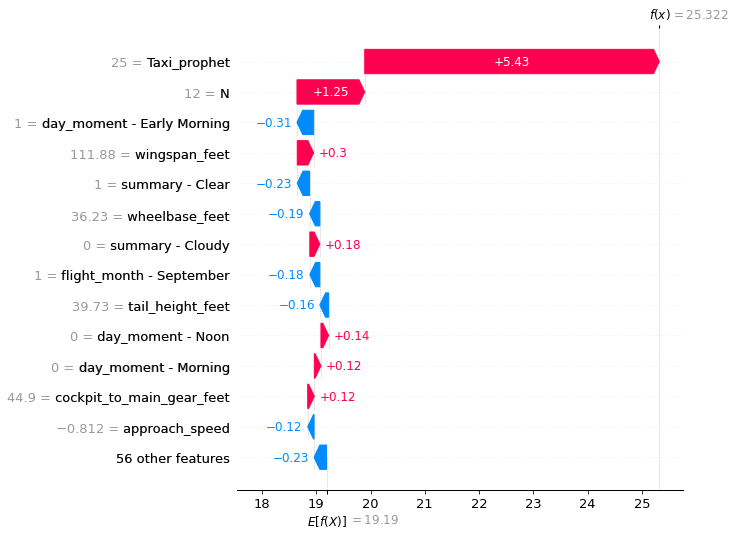

In [399]:
X_train_summary = shap.kmeans(X_train, 50)
X100 = shap.utils.sample(X_train, 100)
explainer = shap.Explainer(reg.predict, X100)
shap_values = explainer(X100)

# make a standard partial dependence plot
sample_ind = 18

# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [340]:
shap.plots.waterfall(shap_values, max_display = 10)

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [331]:
X_test

,temperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,number_engines,...,flight_month - May,flight_month - November,flight_month - October,flight_month - September,day_moment - Early Morning,day_moment - Evening,day_moment - Late Night,day_moment - Morning,day_moment - Night,day_moment - Noon
23780,-1.132828,-1.594524,-0.585536,1.571846,0.380004,0.459286,-1.063706,-0.693813,0.409965,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
58340,-0.531154,-0.011946,1.009705,0.505317,-0.218387,0.615579,0.868380,-0.693813,0.409965,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6201,-0.476539,0.184913,1.328753,-1.577816,-1.327321,-0.436793,-1.719235,-0.693813,0.409965,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
20041,1.815469,1.570631,-0.904584,0.505317,0.173750,0.313413,-1.167210,-0.172165,0.409965,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45748,0.997155,0.184913,-1.478871,-0.513557,1.118445,-1.624618,-1.063706,-0.693813,0.409965,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.014086,-0.212106,-0.521726,1.317694,0.237409,0.469706,-0.201167,0.871131,0.409965,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49200,0.014086,-0.011946,-0.202678,2.075610,1.357801,0.261315,-0.201167,1.914426,0.409965,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38894,-0.640384,-0.606925,0.116370,-0.257137,-0.399178,-0.363856,0.868380,-0.693813,0.409965,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
44697,-0.476539,0.184913,1.328753,-0.107369,1.831422,-1.020286,1.730918,-0.693813,-3.500211,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [347]:
X.columns

Index(['temperature', 'dewPoint', 'humidity', 'windSpeed', 'windGust',
       'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'number_engines',
       'approach_speed', 'wingspan_feet', 'length_feet', 'tail_height_feet',
       'wheelbase_feet', 'cockpit_to_main_gear_feet', 'main_gear_width',
       'max_takeoff_weight', 'max_ramp_taxi_weight',
       'parking_area_square_feet', 'distance', 'N', 'Taxi_prophet',
       'Q_prophet', 'delay', 'taxi_out_mov_avg', 'runway - RUNWAY_1',
       'runway - RUNWAY_2', 'runway - RUNWAY_3', 'runway - RUNWAY_4',
       'summary - Clear', 'summary - Clouds and Wind', 'summary - Cloudy',
       'summary - Dangerously Windy', 'summary - Drizzle', 'summary - Foggy',
       'summary - Possible Drizzle', 'summary - Possible Light Rain',
       'summary - Rain', 'summary - Rain and Wind', 'engine class - Jet',
       'engine class - Turboprop', 'wingtip_config - no winglets',
       'wingtip_config - winglets', 'wingtip_config - wingtip fences',
    